In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from glob import glob
import mplfinance as mpf
import matplotlib.dates as mpl_dates


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


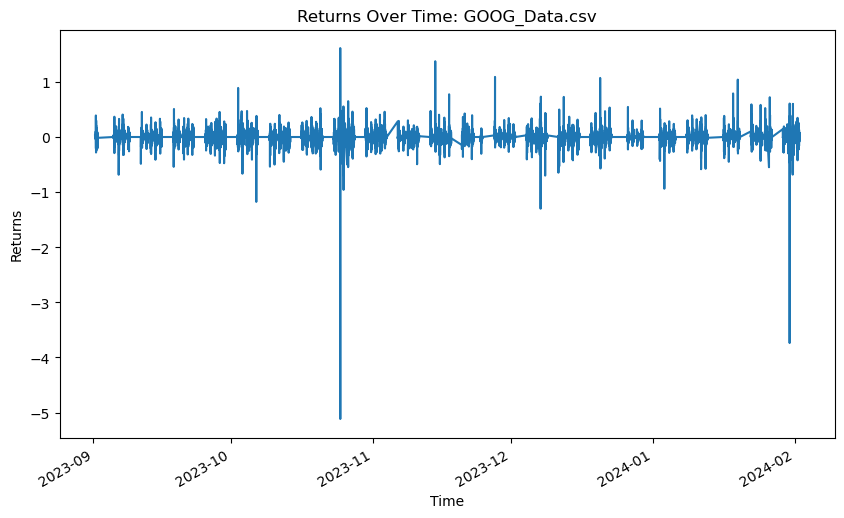

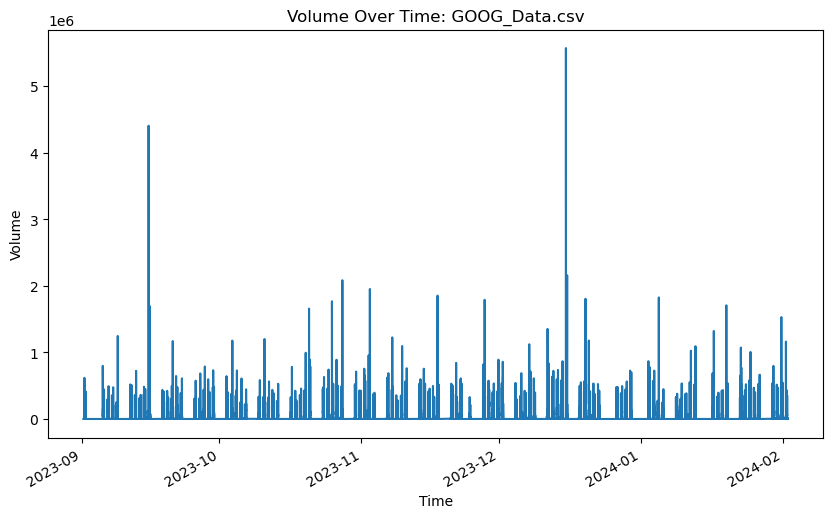

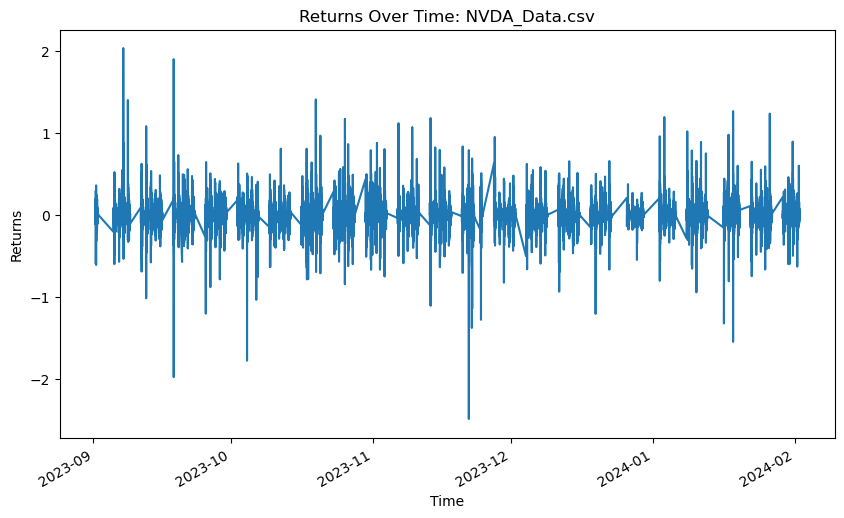

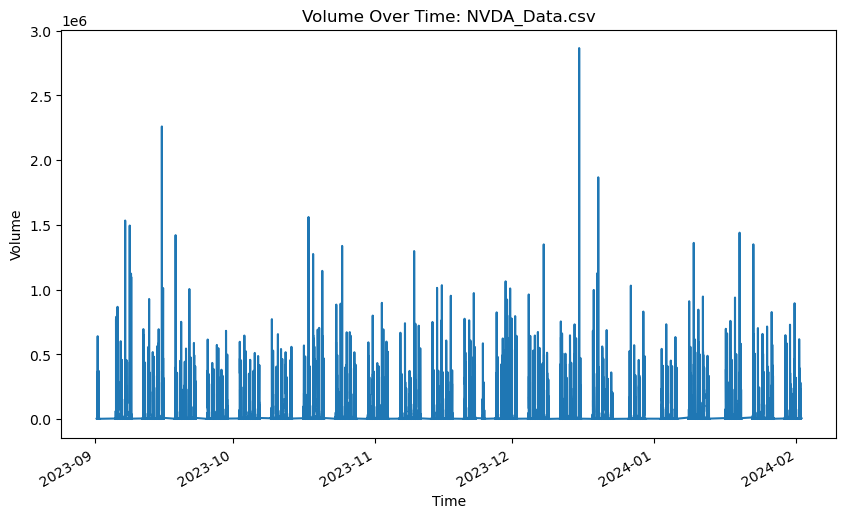

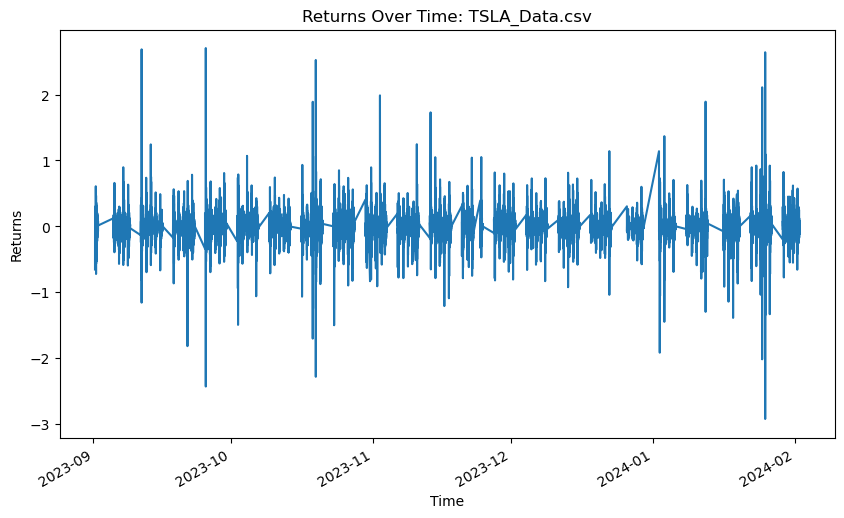

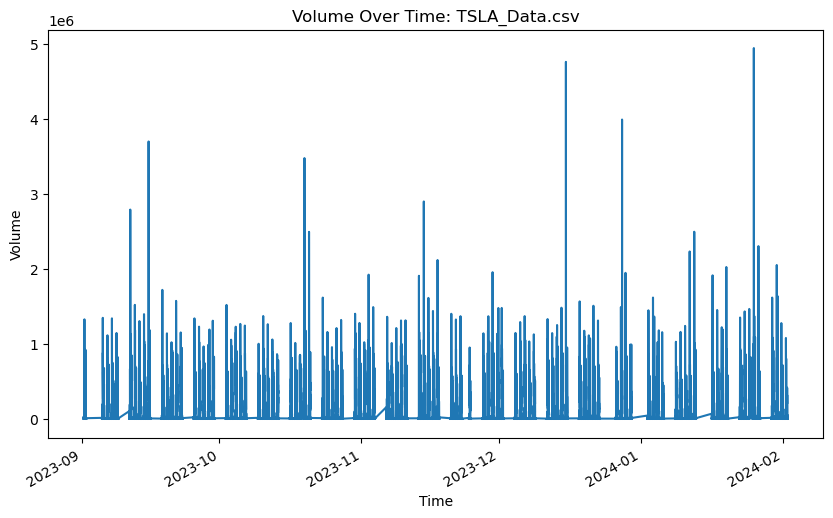

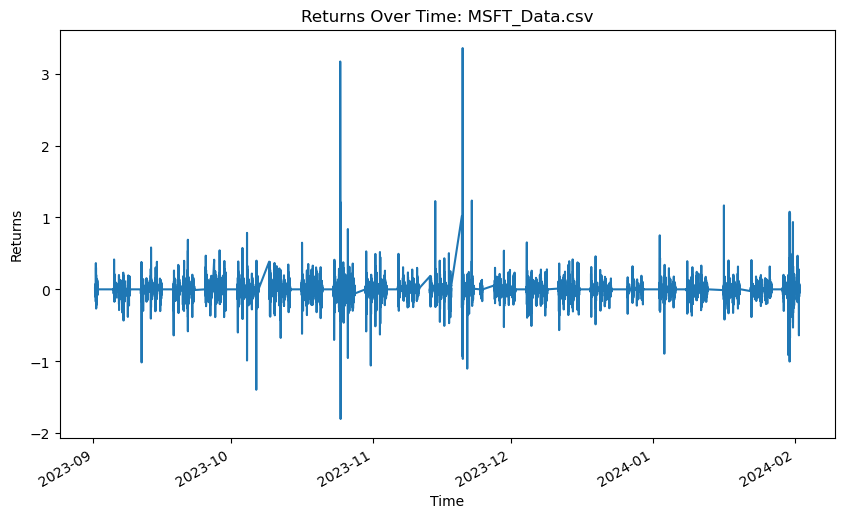

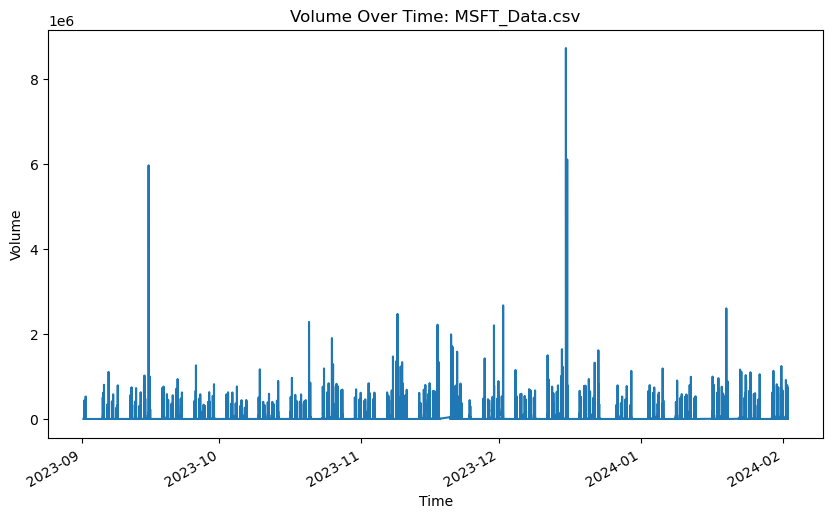

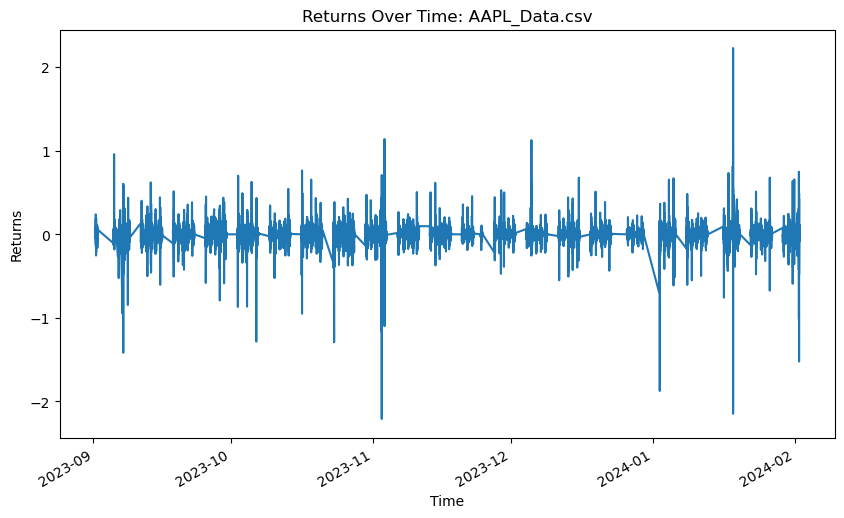

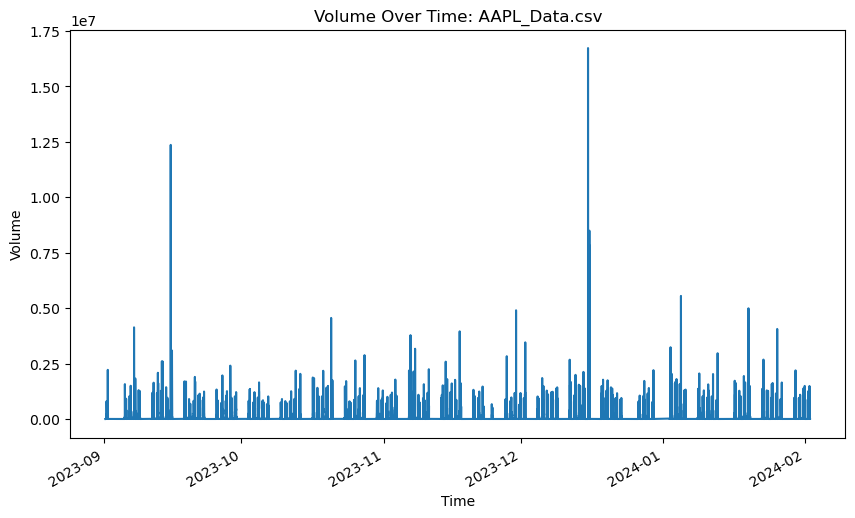

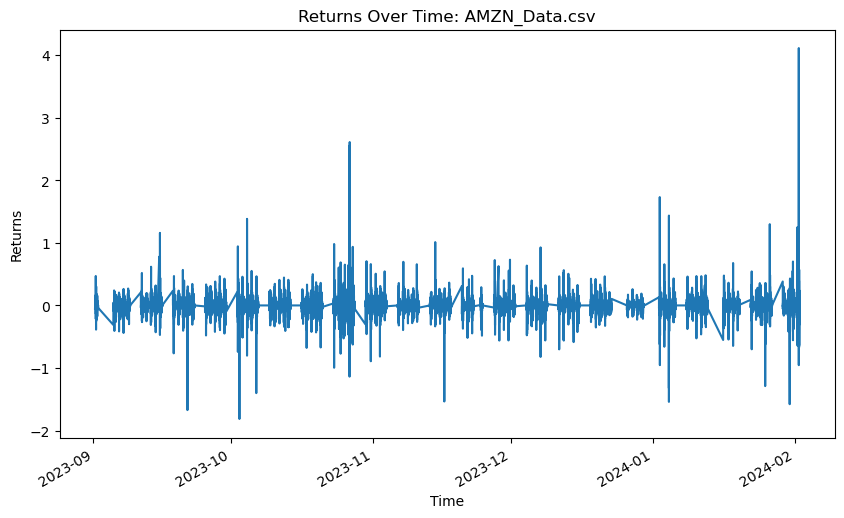

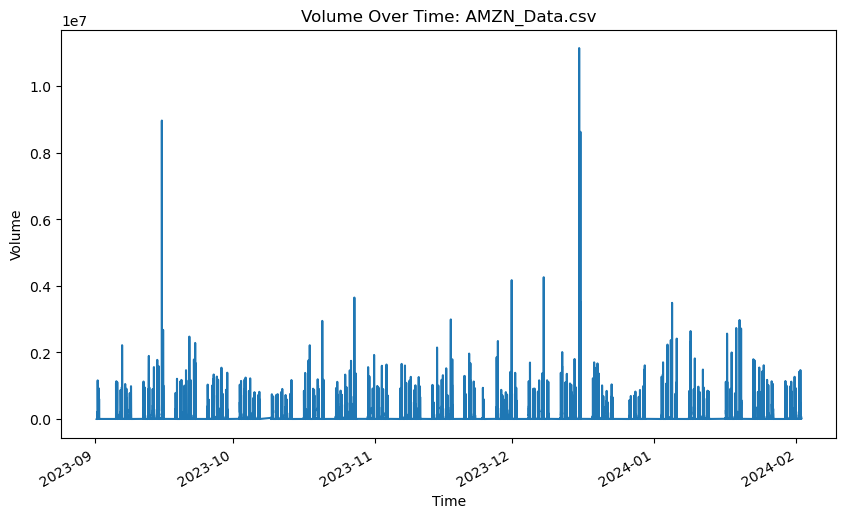

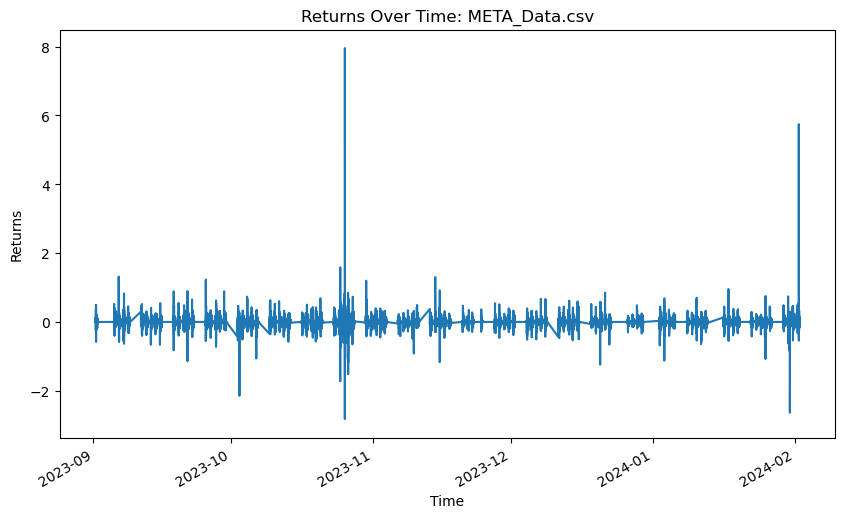

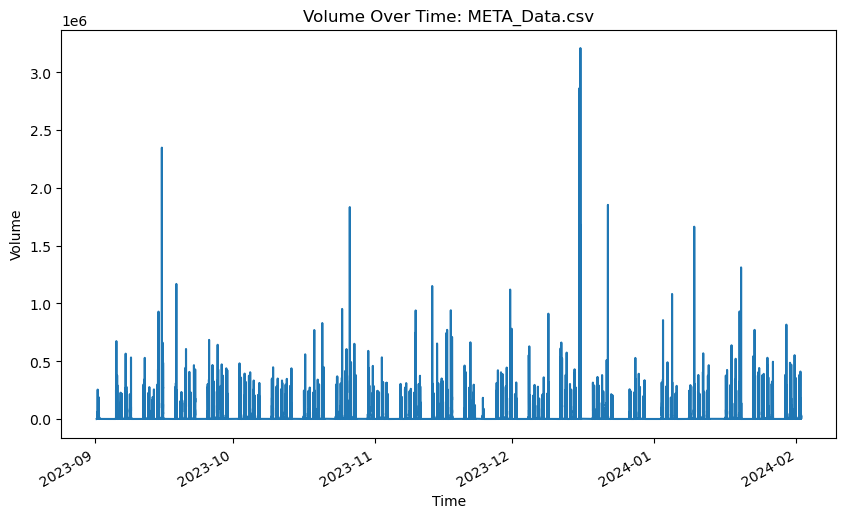

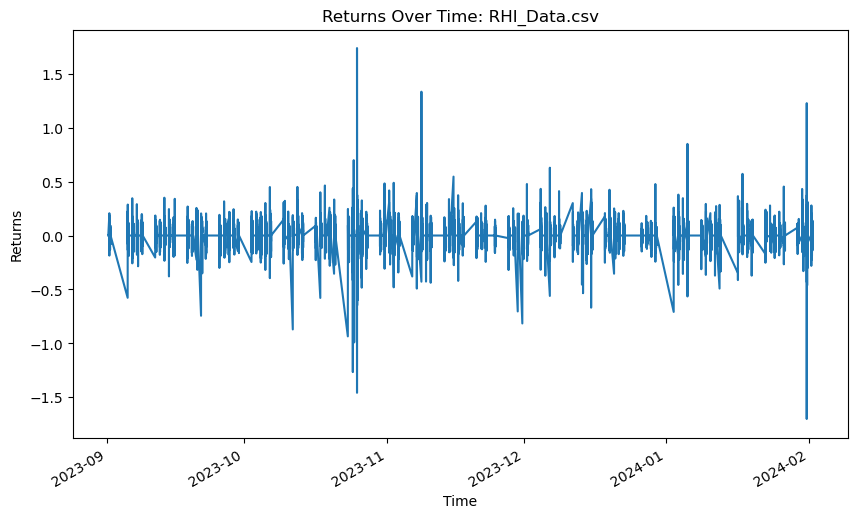

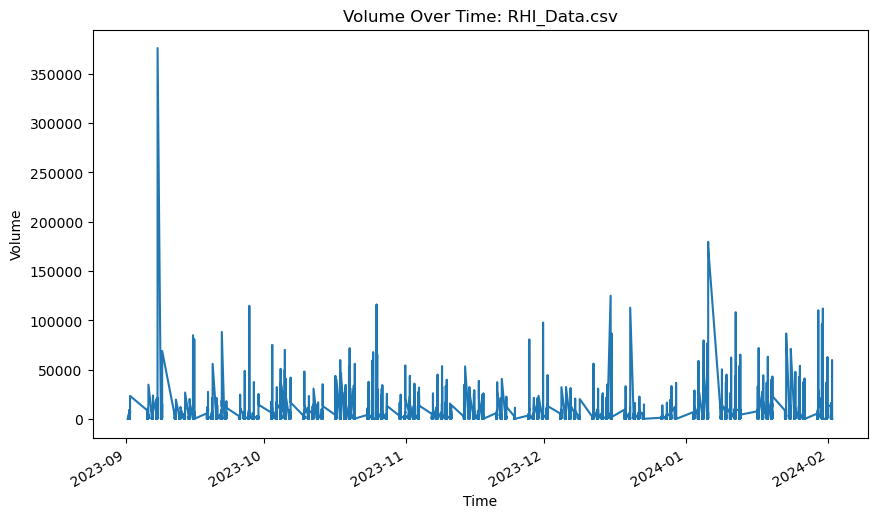

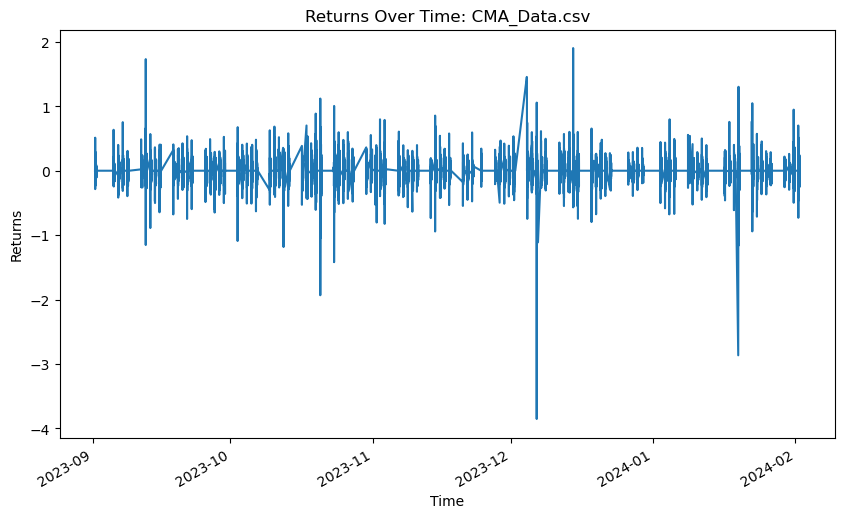

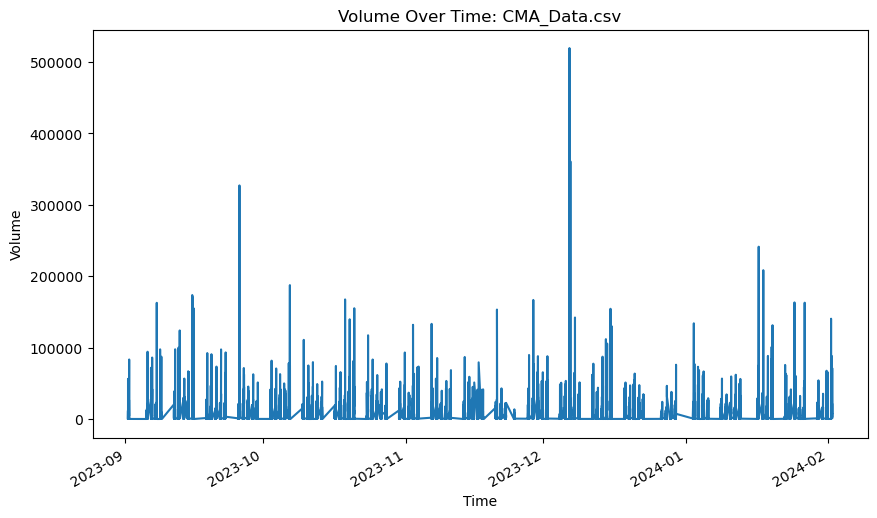

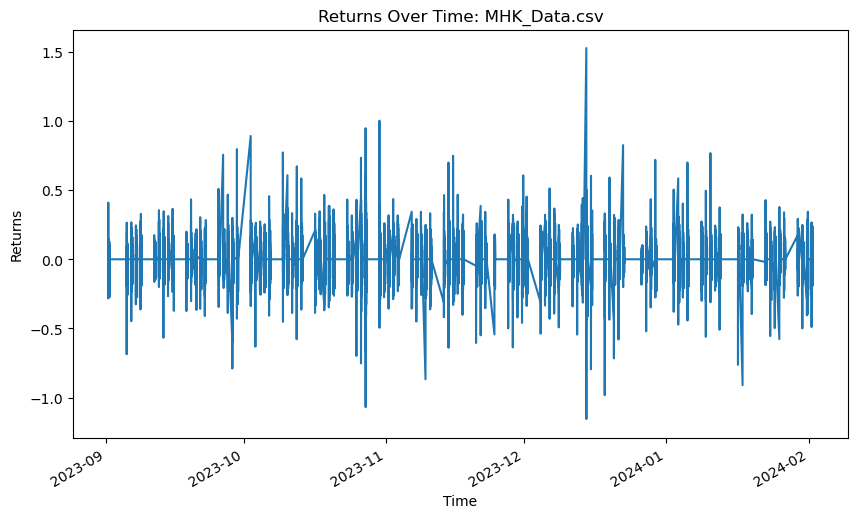

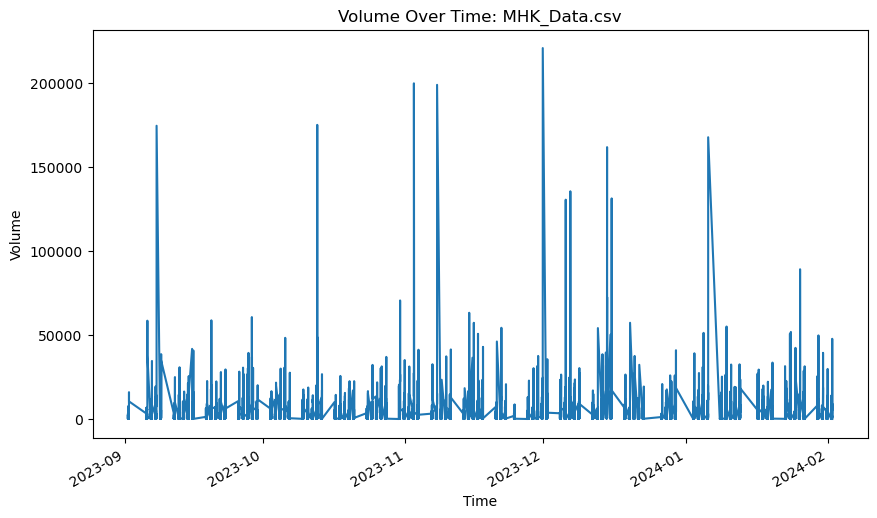

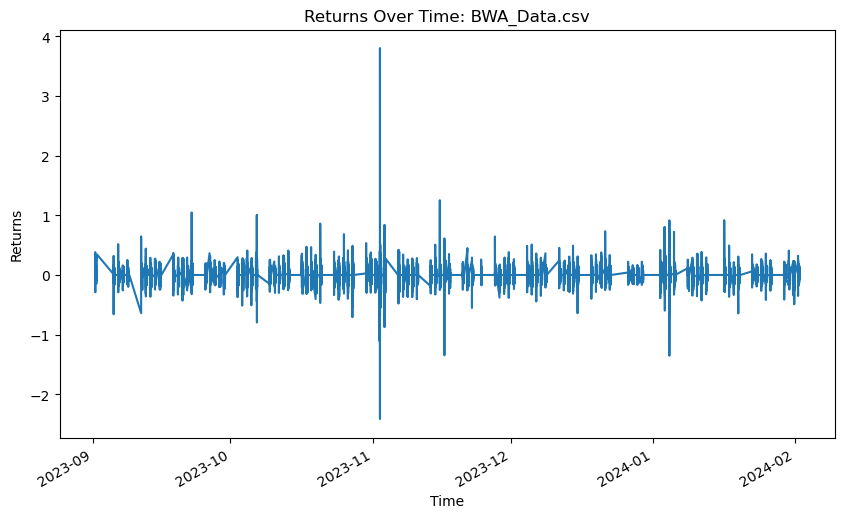

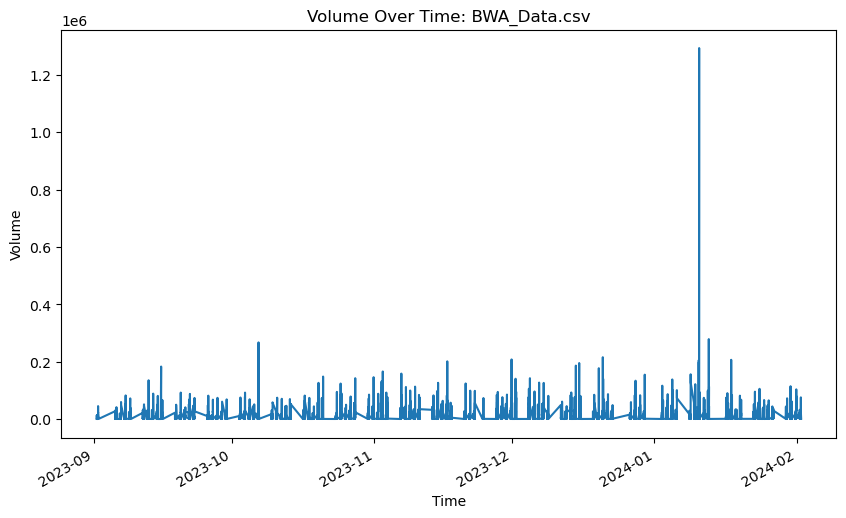

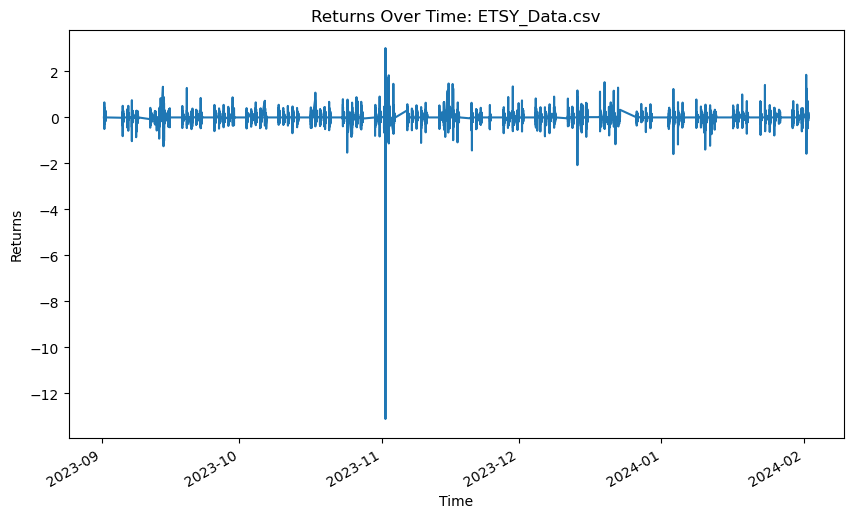

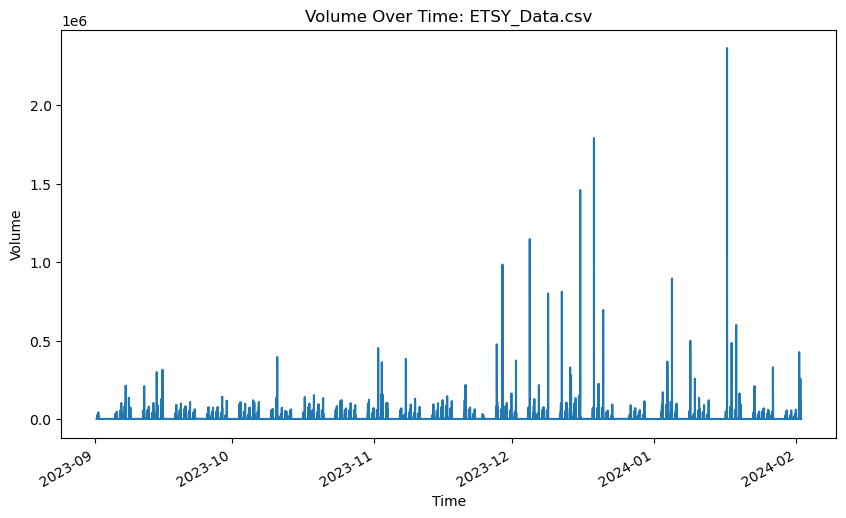

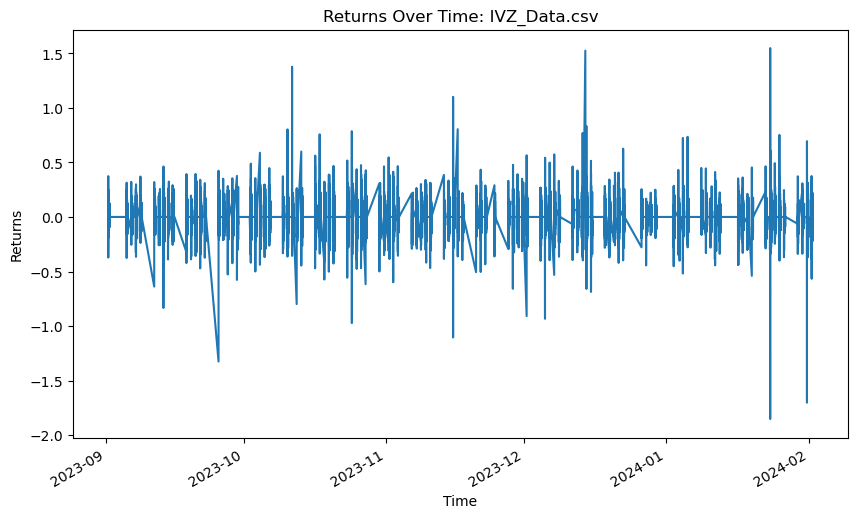

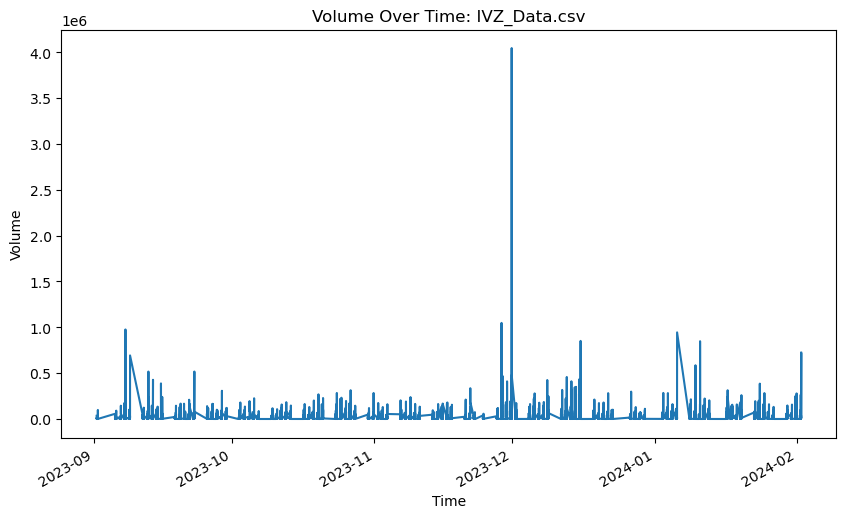

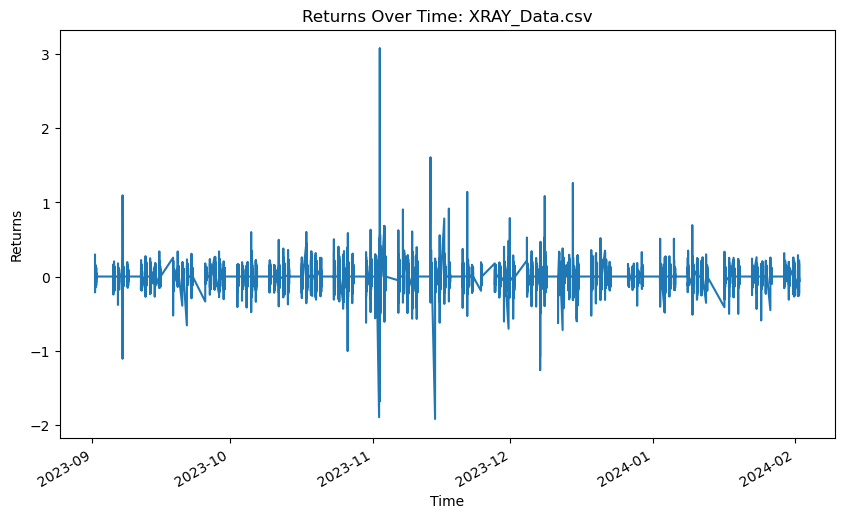

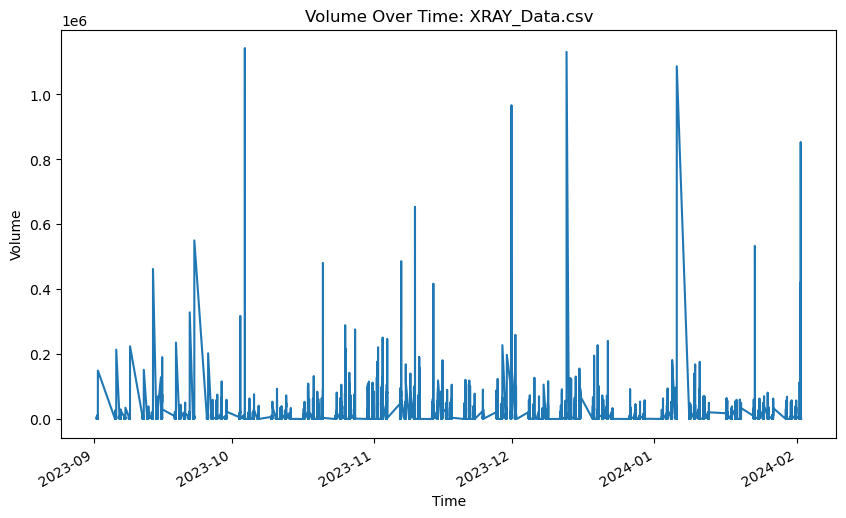

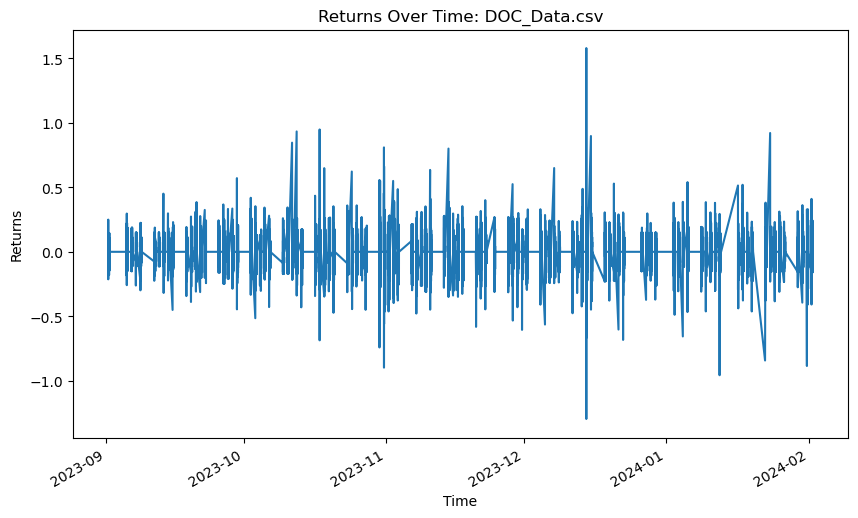

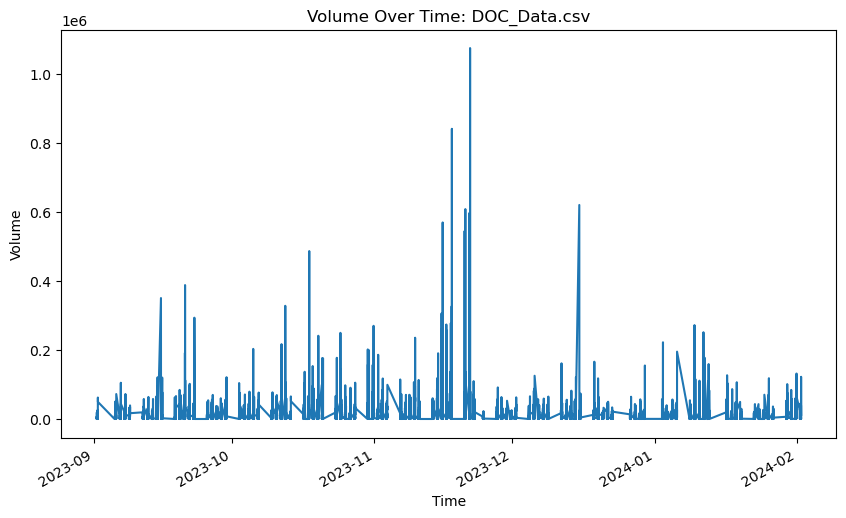

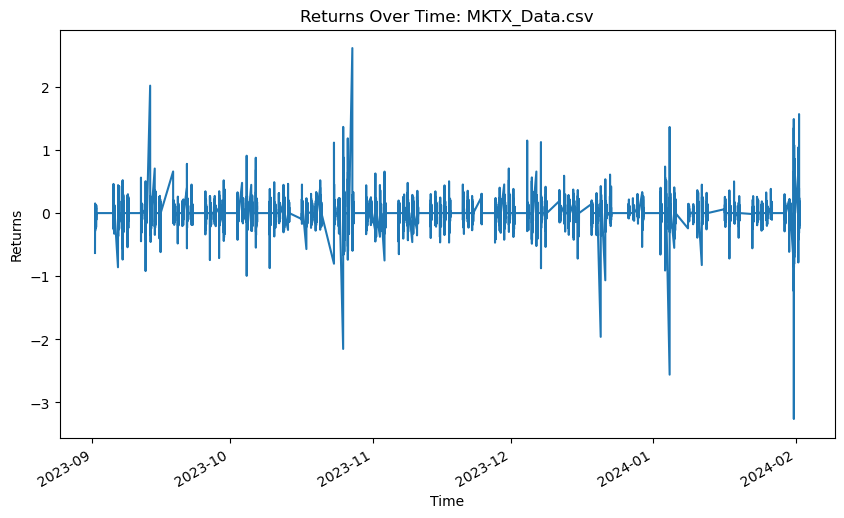

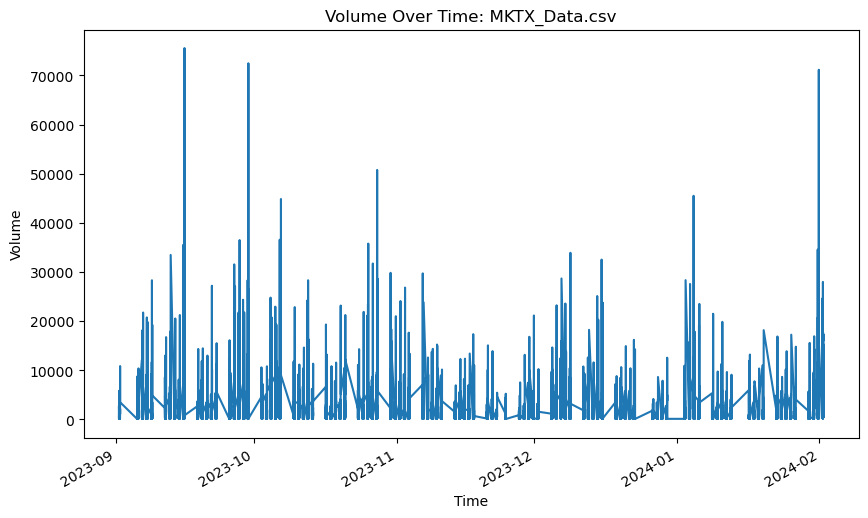

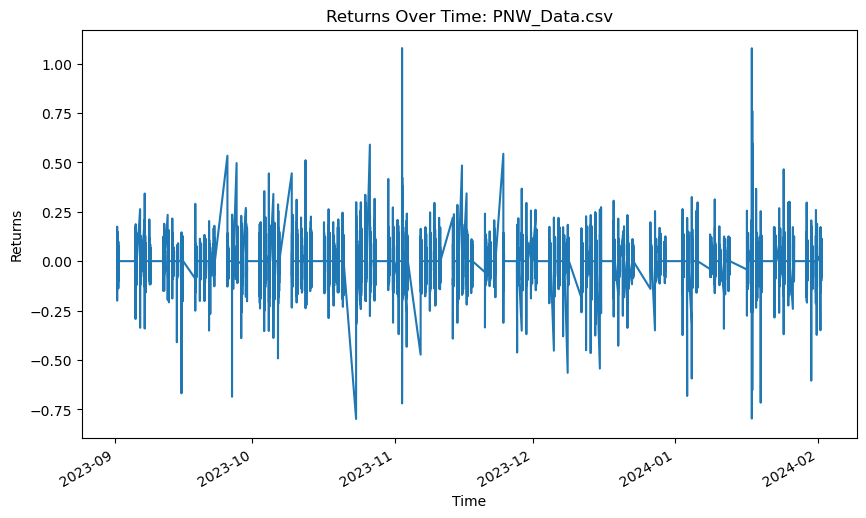

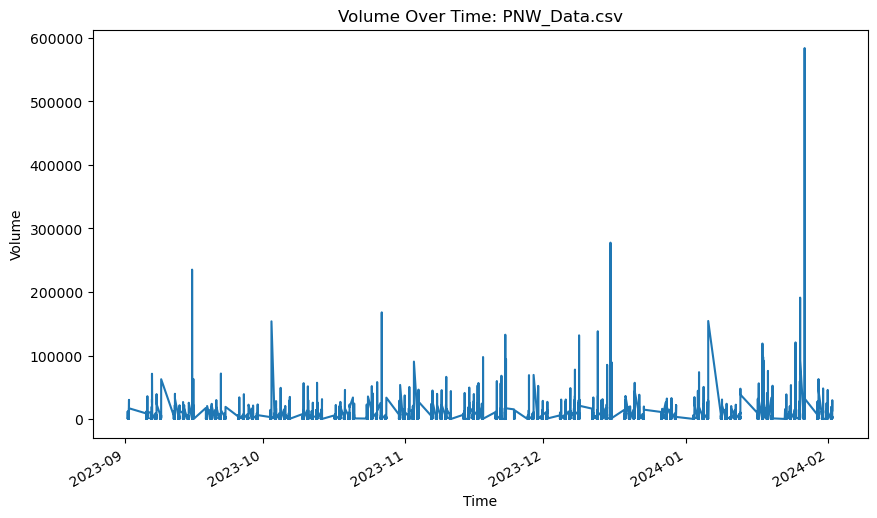

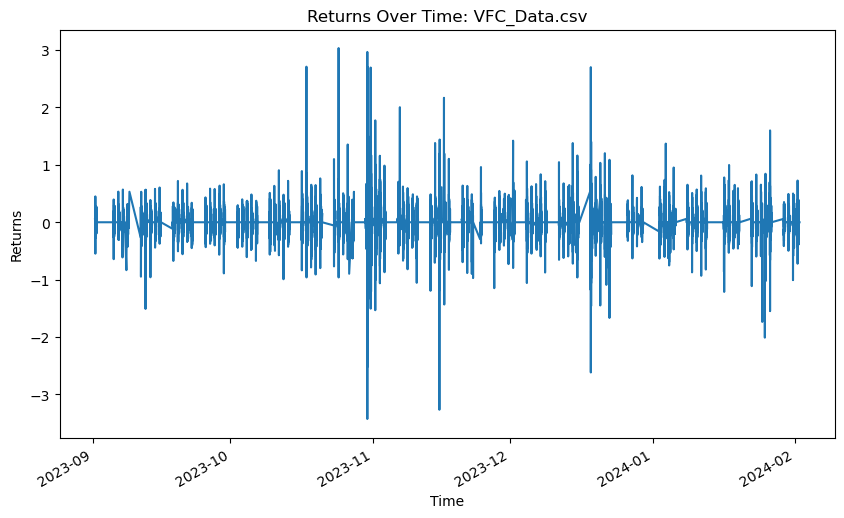

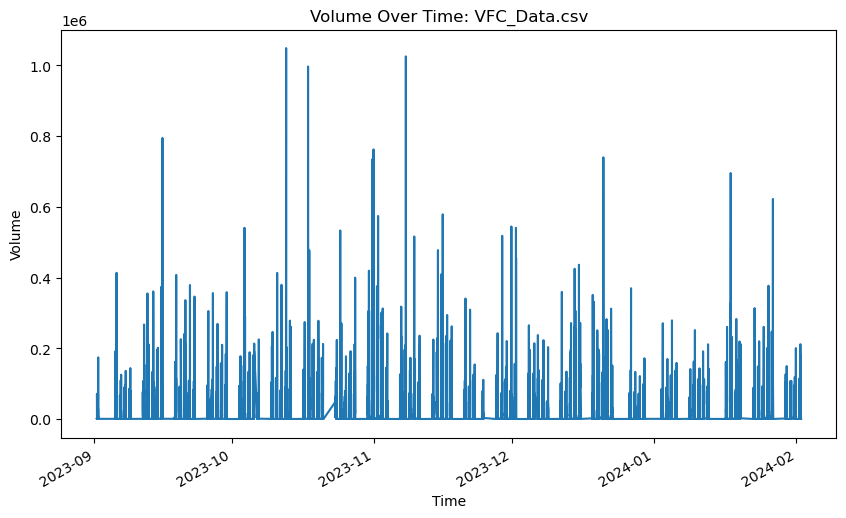

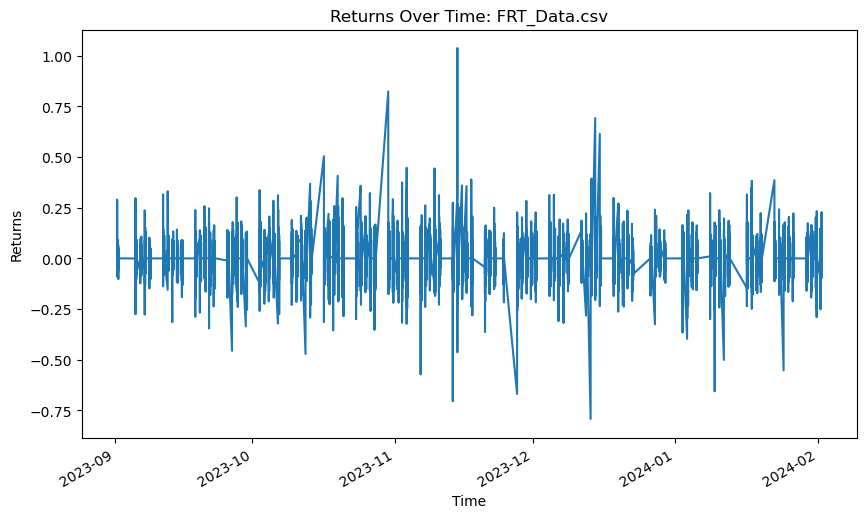

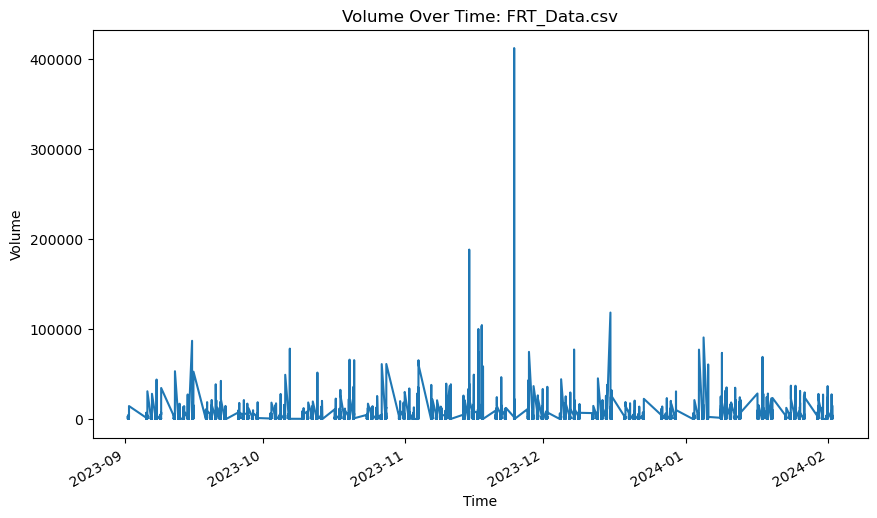

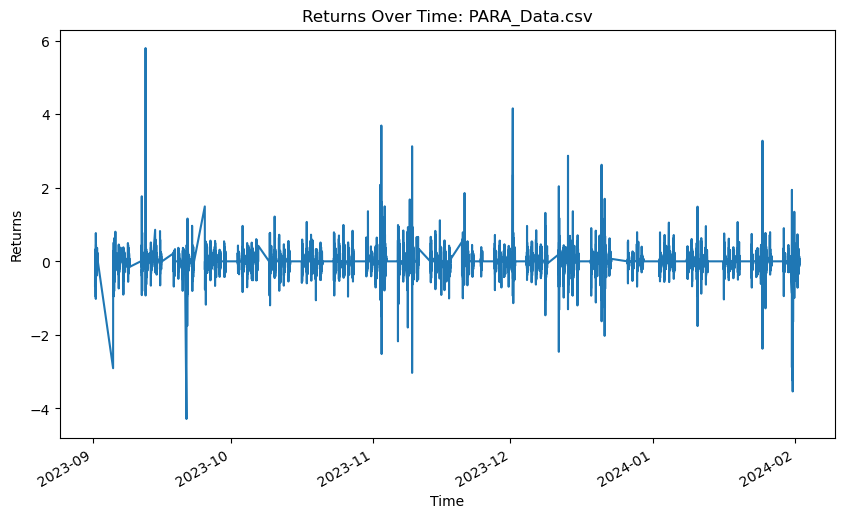

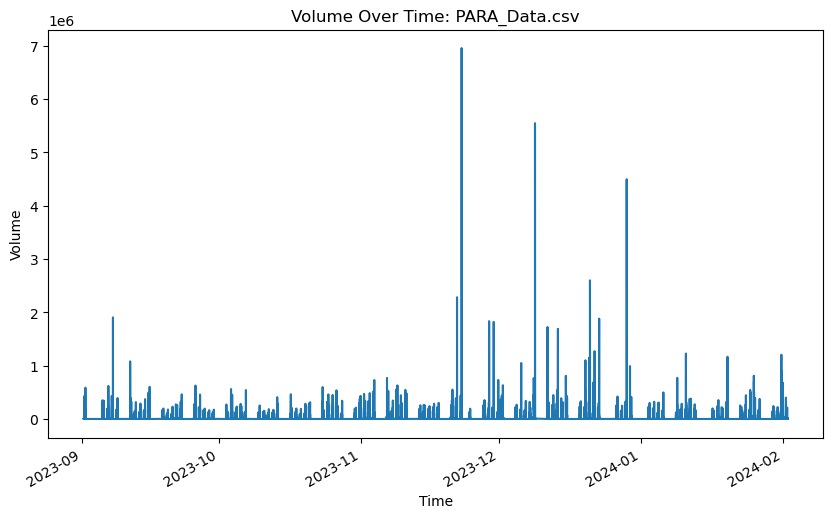

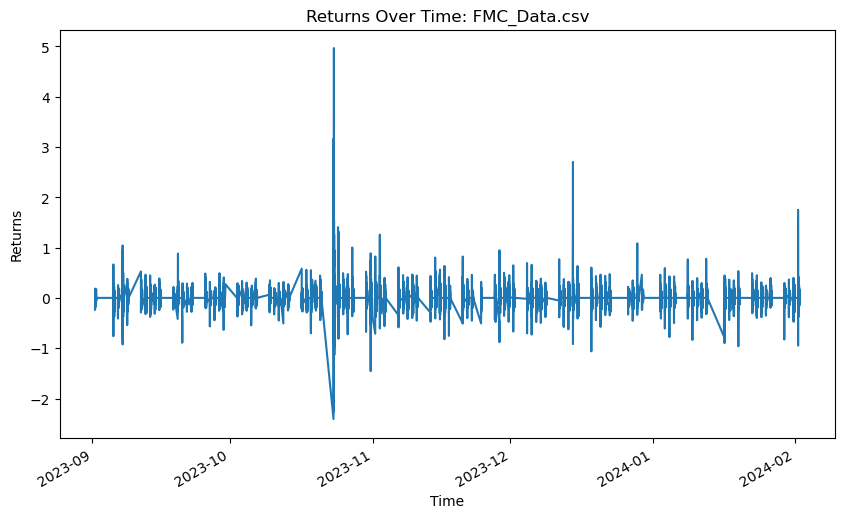

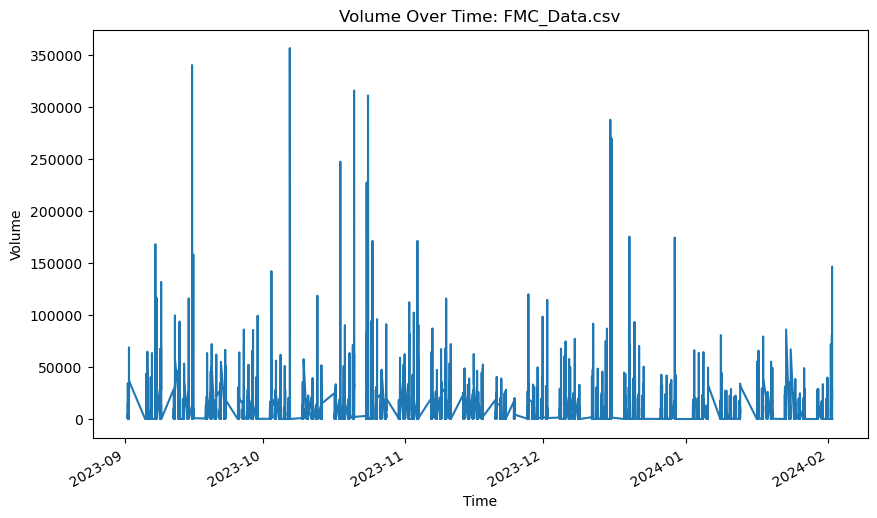

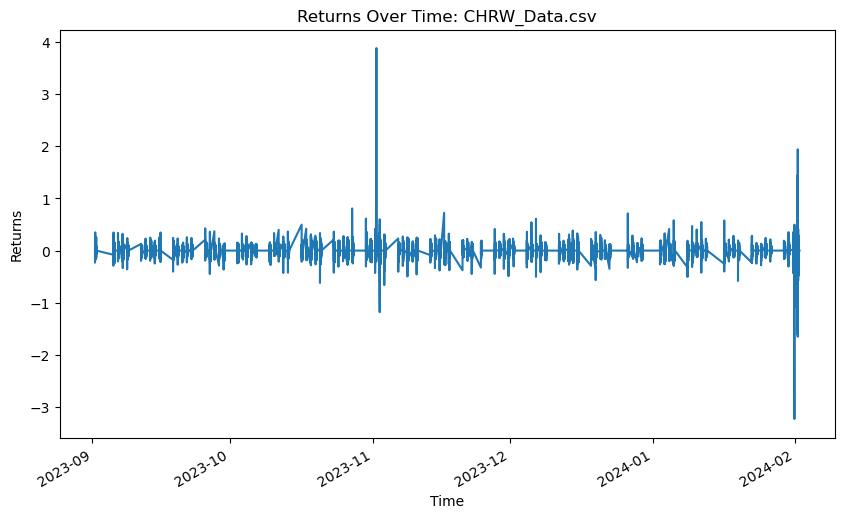

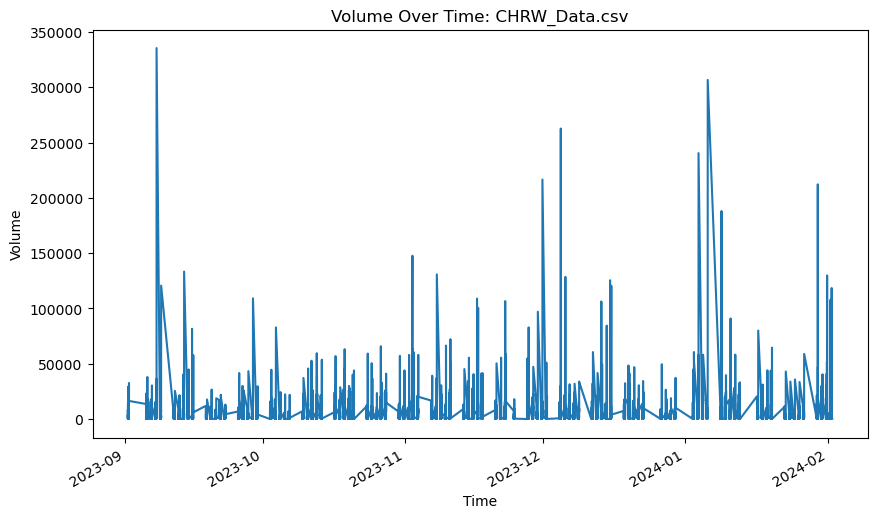

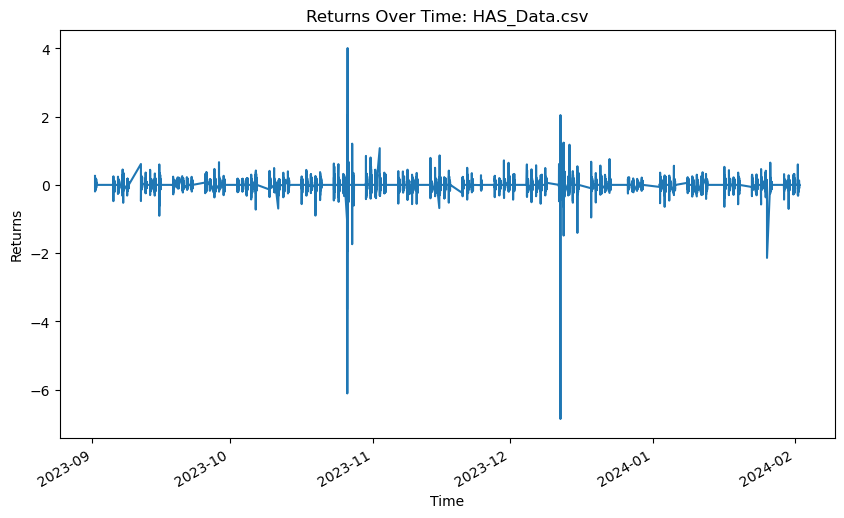

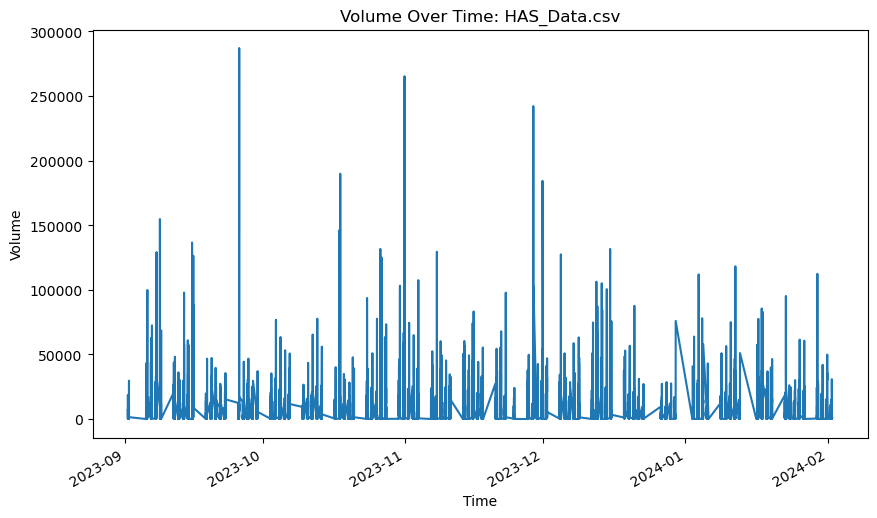

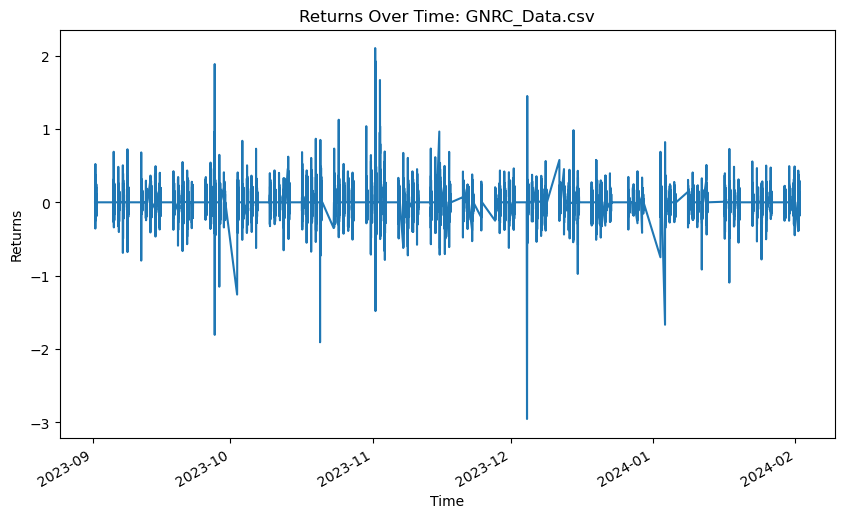

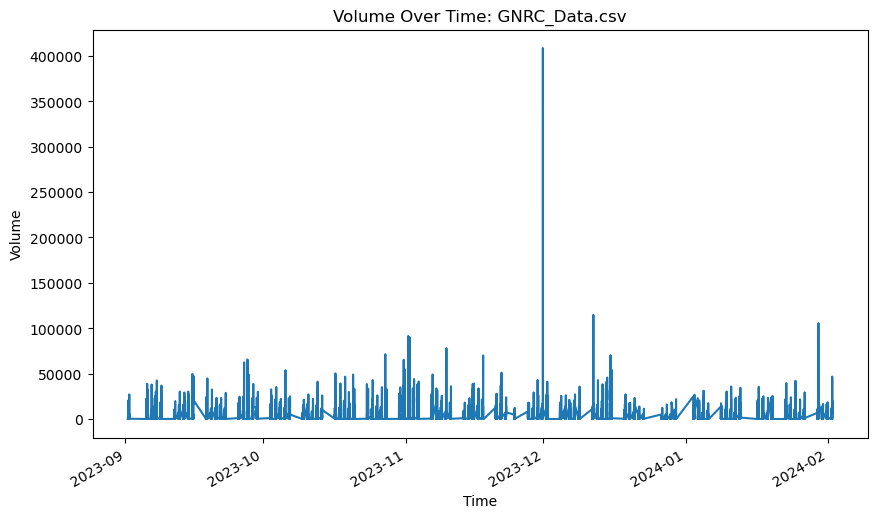

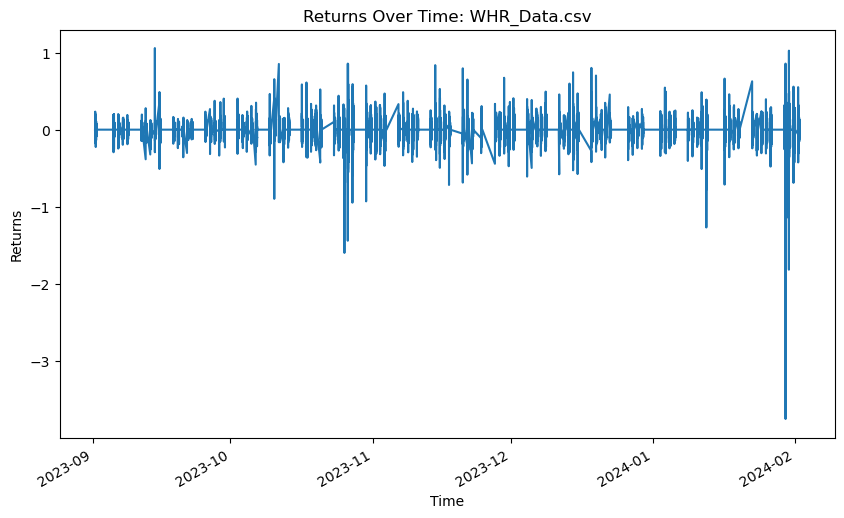

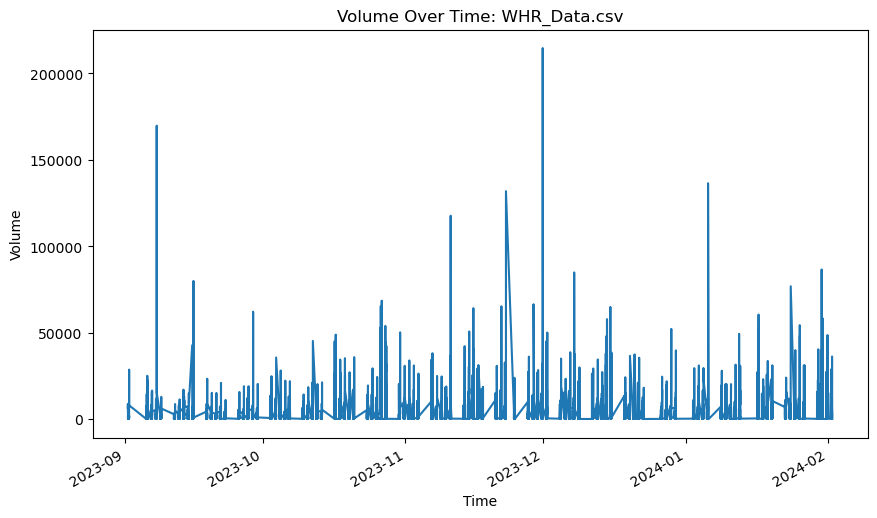

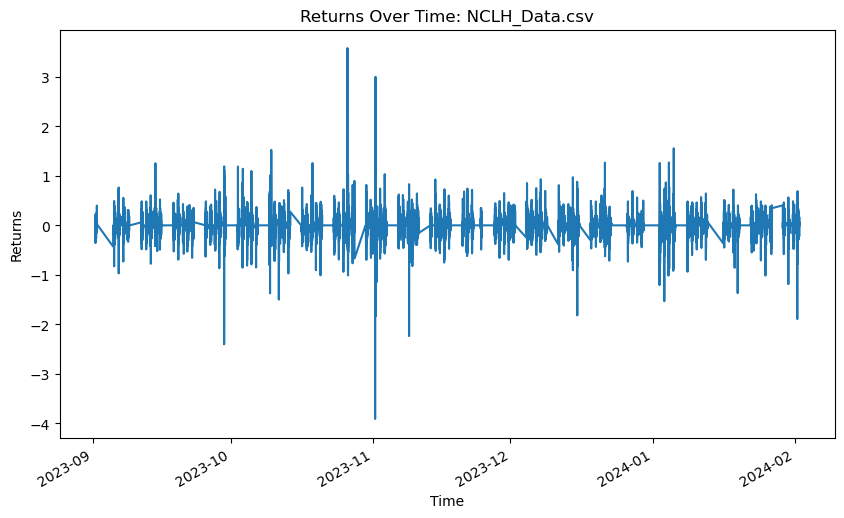

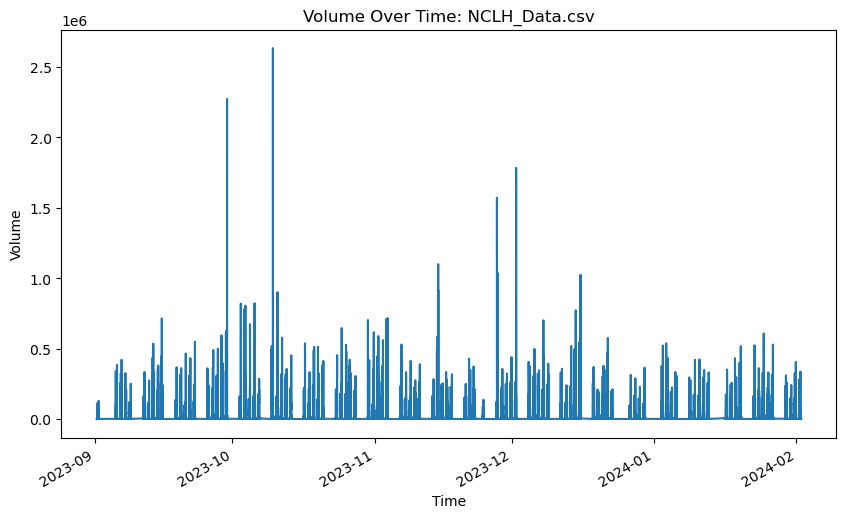

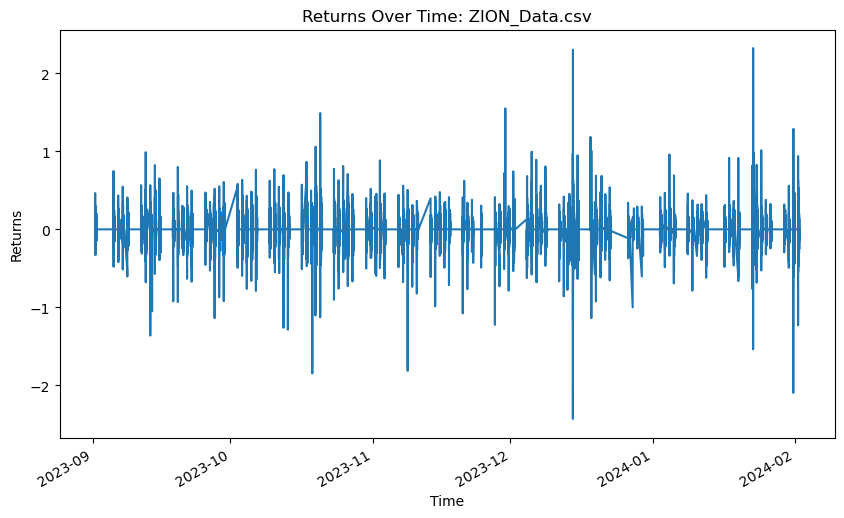

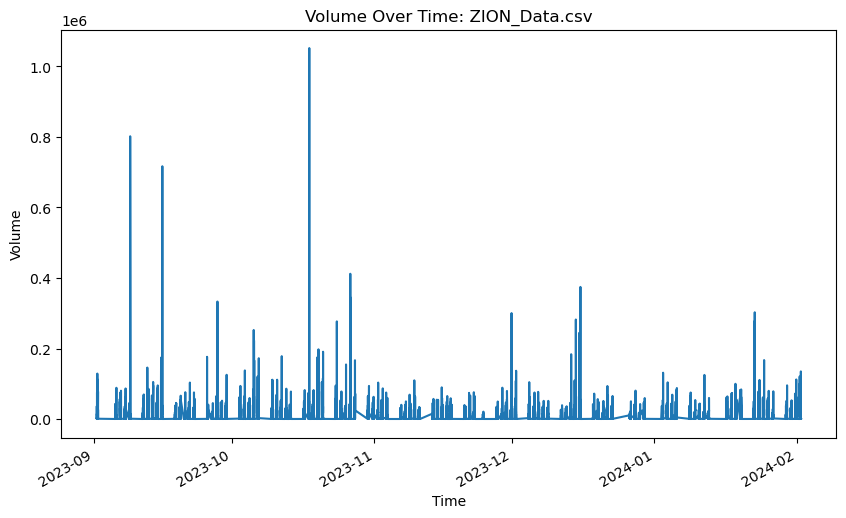

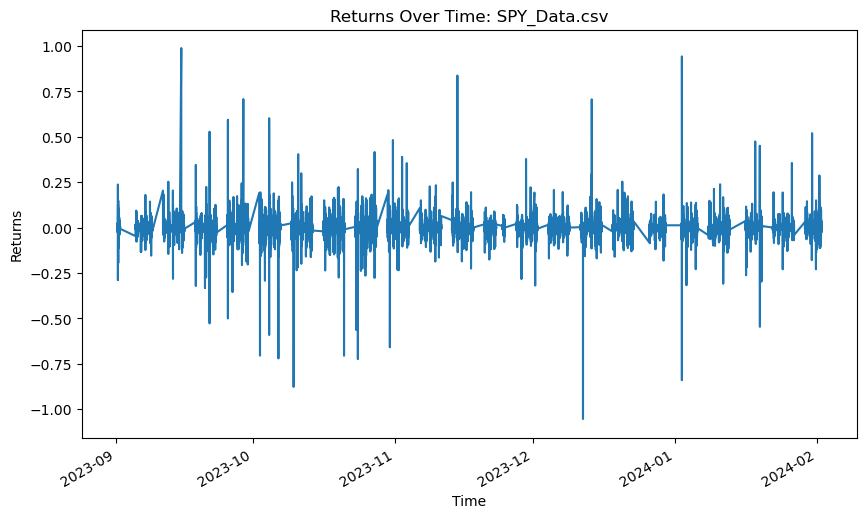

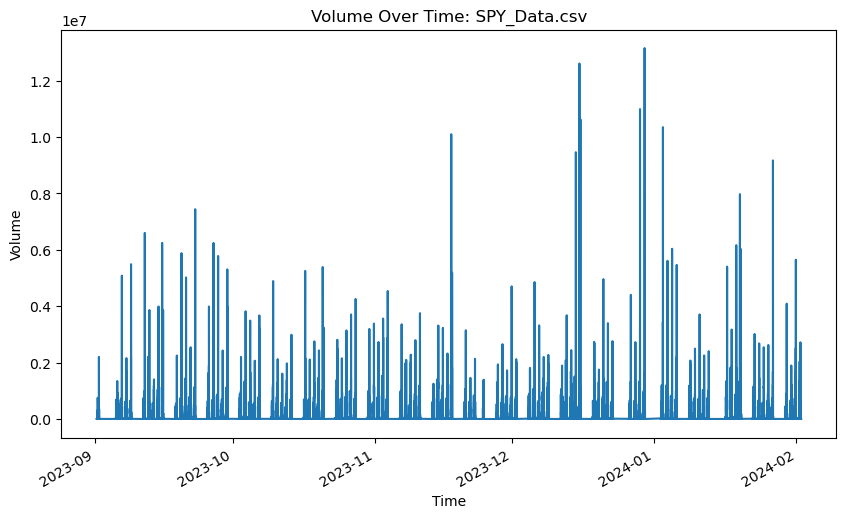

In [2]:
def plot_data_for_company(file_path):
    # Load data
    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data.set_index('timestamp', inplace=True)
    
    # Plotting
    # Returns over time
    plt.figure(figsize=(10, 6))
    data['returns'].plot(title=f"Returns Over Time: {os.path.basename(file_path)}")
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.show()
    
    # Volume over time
    plt.figure(figsize=(10, 6))
    data['volume'].plot(title=f"Volume Over Time: {os.path.basename(file_path)}")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.show()

def process_folder(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                plot_data_for_company(os.path.join(root, file))

# Processing each folder
process_folder('Data/Mag_7')
process_folder('Data/Bottom_20')

# For SPY_Data.csv
plot_data_for_company('data/SPY_Data.csv')


<Figure size 1400x600 with 0 Axes>

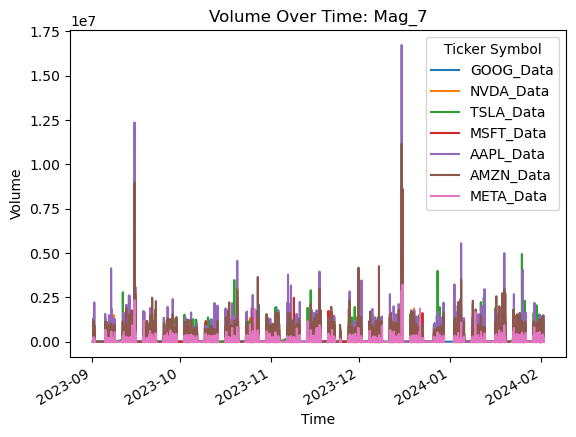

<Figure size 1400x600 with 0 Axes>

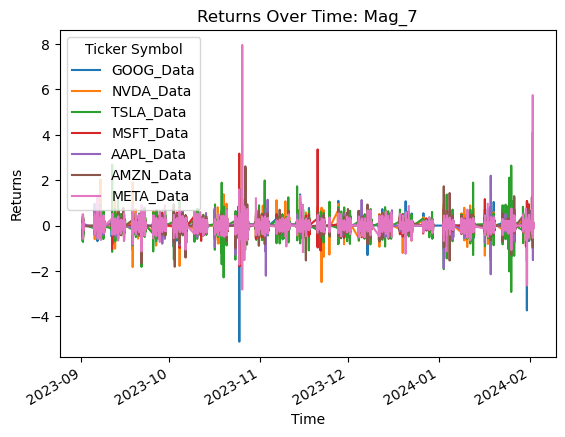

<Figure size 1400x600 with 0 Axes>

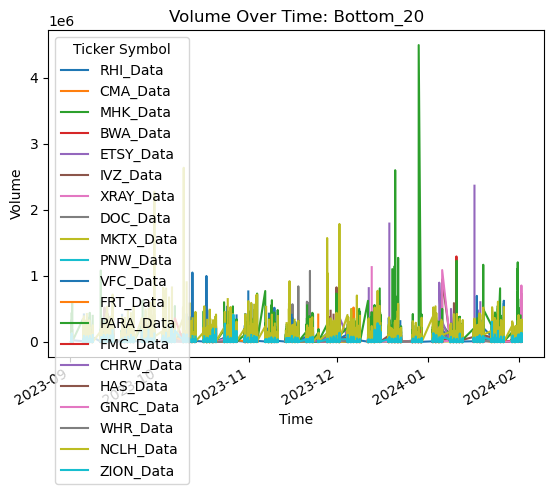

<Figure size 1400x600 with 0 Axes>

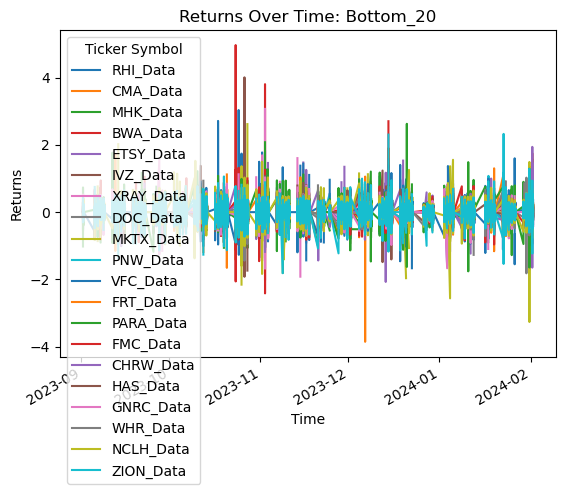

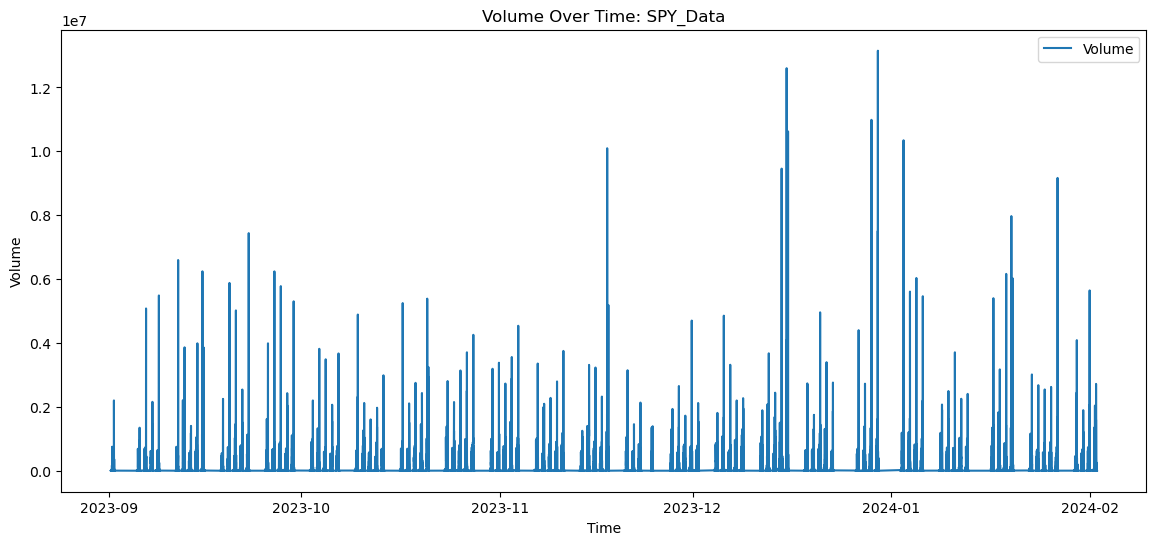

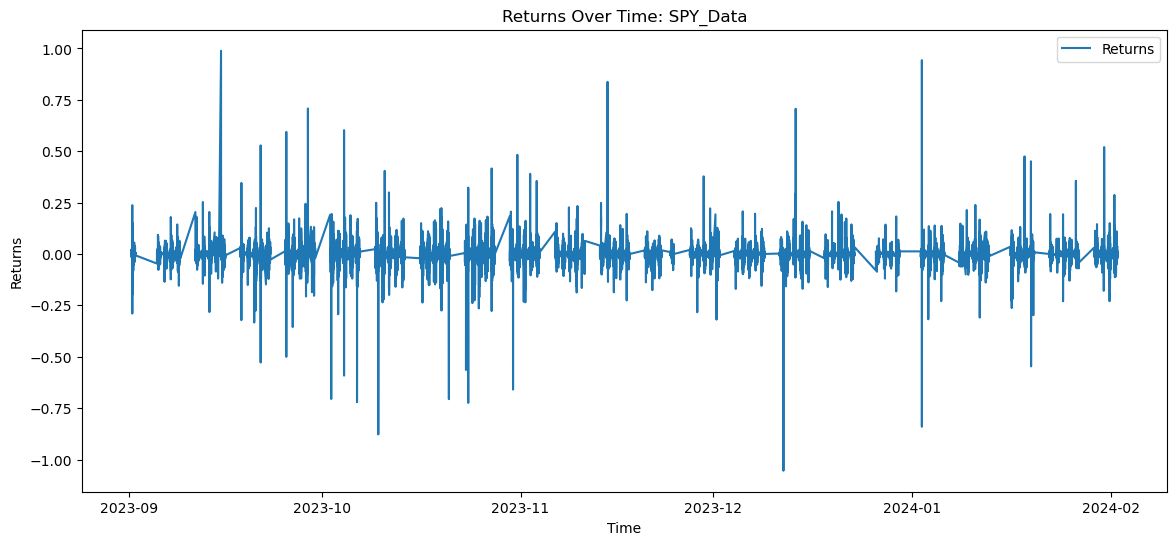

In [3]:
def collect_and_plot_data(folder_path, category):
    volume_data = pd.DataFrame()
    returns_data = pd.DataFrame()
    
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".csv"):
                file_path = os.path.join(root, file)
                data = pd.read_csv(file_path)
                data['timestamp'] = pd.to_datetime(data['timestamp'])
                
                # Extract the ticker symbol from the filename
                ticker_symbol = os.path.splitext(file)[0]
                
                # Aggregate volume and returns data
                volume_data[ticker_symbol] = data.set_index('timestamp')['volume']
                returns_data[ticker_symbol] = data.set_index('timestamp')['returns']
    
    # Plot aggregated volume data
    plt.figure(figsize=(14, 6))
    volume_data.plot(title=f"Volume Over Time: {category}", xlabel='Time', ylabel='Volume')
    plt.legend(title='Ticker Symbol')
    plt.show()
    
    # Plot aggregated returns data
    plt.figure(figsize=(14, 6))
    returns_data.plot(title=f"Returns Over Time: {category}", xlabel='Time', ylabel='Returns')
    plt.legend(title='Ticker Symbol')
    plt.show()

# Collect and plot data for Mag_7 and Bottom_20
collect_and_plot_data('data/Mag_7', 'Mag_7')
collect_and_plot_data('data/Bottom_20', 'Bottom_20')

def plot_spy_data(file_path):
    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    ticker_symbol = os.path.splitext(os.path.basename(file_path))[0]
    
    # Plot volume
    plt.figure(figsize=(14, 6))
    plt.plot(data['timestamp'], data['volume'], label='Volume')
    plt.title(f"Volume Over Time: {ticker_symbol}")
    plt.xlabel('Time')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()
    
    # Plot returns
    plt.figure(figsize=(14, 6))
    plt.plot(data['timestamp'], data['returns'], label='Returns')
    plt.title(f"Returns Over Time: {ticker_symbol}")
    plt.xlabel('Time')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

plot_spy_data('data/SPY_Data.csv')

In [9]:
from collections import defaultdict

def calculate_modified_average_returns(folder_path):
    results = defaultdict(lambda: np.zeros(6))  # Holds returns for Sep-Jan + overall average

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            # Load and preprocess data
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path)
            data['timestamp'] = pd.to_datetime(data['timestamp'])
            data['date'] = data['timestamp'].dt.date
            data['month'] = data['timestamp'].dt.month
            data['year'] = data['timestamp'].dt.year

            # Correct handling for January data of the next year
            # Adjust month values to ensure September to January are treated as consecutive months
            data['adjusted_month'] = data['month']
            data.loc[data['month'] == 1, 'adjusted_month'] = 13  # Treat January as the month after December for calculation purposes
            
            # Exclude incomplete February data
            data = data[data['adjusted_month'] != 2]
            
            # Calculate daily returns as close - open
            data['daily_return'] = data['close'] - data['open']
            
            # Sum daily returns by month and calculate the average
            monthly_returns_sum = data.groupby('adjusted_month')['daily_return'].sum()
            days_in_month = data.groupby('adjusted_month')['date'].nunique()
            monthly_avg_returns = monthly_returns_sum / days_in_month
            
            # Calculate the overall average return, excluding February
            overall_avg_return = monthly_avg_returns.mean()
            
            # Store results
            ticker_symbol = os.path.splitext(file)[0].replace('_Data', '')
            for i, month in enumerate([9, 10, 11, 12, 13]):  # Adjusted for Sep-Jan as 9-13
                results[ticker_symbol][i] = monthly_avg_returns.get(month, np.nan)
            results[ticker_symbol][-1] = overall_avg_return

    # Convert results to DataFrame and adjust index
    index_names = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Overall']
    results_df = pd.DataFrame(results, index=index_names)
    return results_df

# Calculate and display the average returns
mag_7_avg_returns = calculate_modified_average_returns('data/Mag_7')
bottom_20_avg_returns = calculate_modified_average_returns('data/Bottom_20')

# Saving to CSV
mag_7_avg_returns.to_csv("mag_7_modified_avg_returns.csv")
bottom_20_avg_returns.to_csv("bottom_20_modified_avg_returns.csv")



In [11]:
def calculate_spy_returns(file_path, output_file):
    data = pd.read_csv(file_path)
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['date'] = data['timestamp'].dt.date
    data['month'] = data['timestamp'].dt.month
    data['year'] = data['timestamp'].dt.year

    # Correct handling for January data of the next year
    # Adjust month values to ensure September to January are treated as consecutive months
    data['adjusted_month'] = data['month']
    data.loc[data['month'] == 1, 'adjusted_month'] = 13  # Treat January as the month after December for calculation purposes

    # Exclude incomplete February data
    data = data[(data['adjusted_month'] != 2) | (data['year'] != 2023)]

    # Calculate daily returns as close - open
    data['daily_return'] = data['close'] - data['open']
    
    # Sum daily returns by month and calculate the average
    monthly_returns_sum = data.groupby('adjusted_month')['daily_return'].sum()
    days_in_month = data.groupby('adjusted_month')['date'].nunique()
    monthly_avg_returns = monthly_returns_sum / days_in_month

    # Calculate the overall average return, excluding February
    overall_avg_return = monthly_avg_returns.mean()

    # Prepare results DataFrame
    results = {'SPY': monthly_avg_returns.tolist() + [overall_avg_return]}
    index_names = ['Sep', 'Oct', 'Nov', 'Dec', 'Jan', "Feb", 'Overall']  # Adjust index to match the months processed
    results_df = pd.DataFrame(results, index=index_names)

    # Write to CSV
    results_df.to_csv(output_file)

    return results_df

# Example usage
spy_avg_returns = calculate_spy_returns('data/SPY_Data.csv', 'spy_avg_returns_modified.csv')

In [14]:
mag_7_avg_returns = pd.read_csv('mag_7_modified_avg_returns.csv', index_col=0)
bottom_20_avg_returns = pd.read_csv('bottom_20_modified_avg_returns.csv', index_col=0)
spy_avg_returns = pd.read_csv('spy_avg_returns_modified.csv', index_col=0)



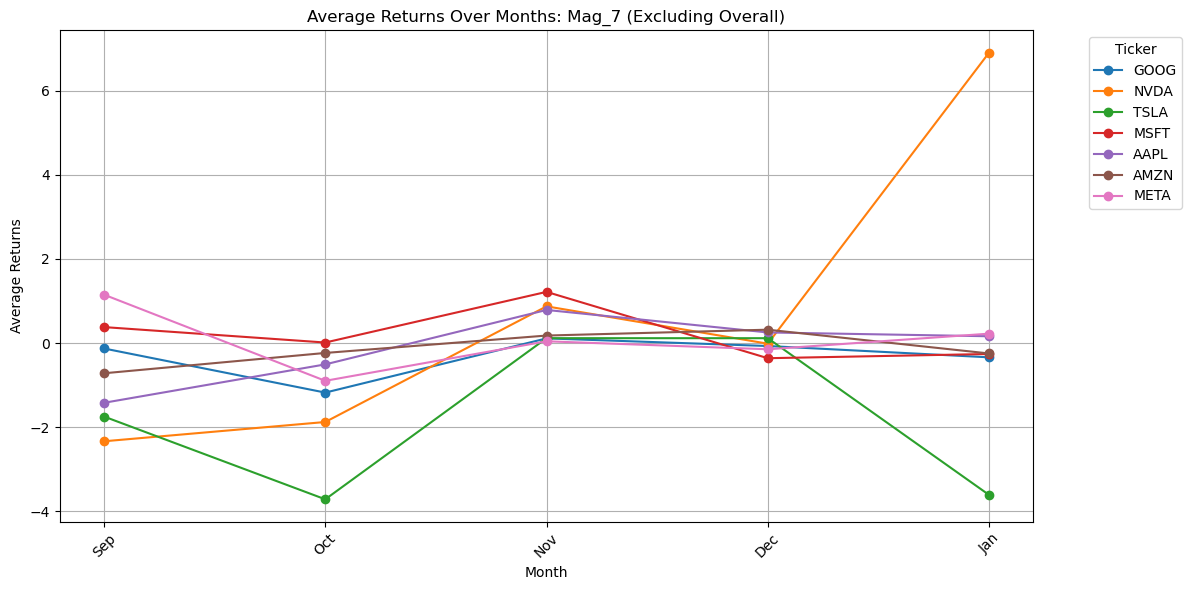

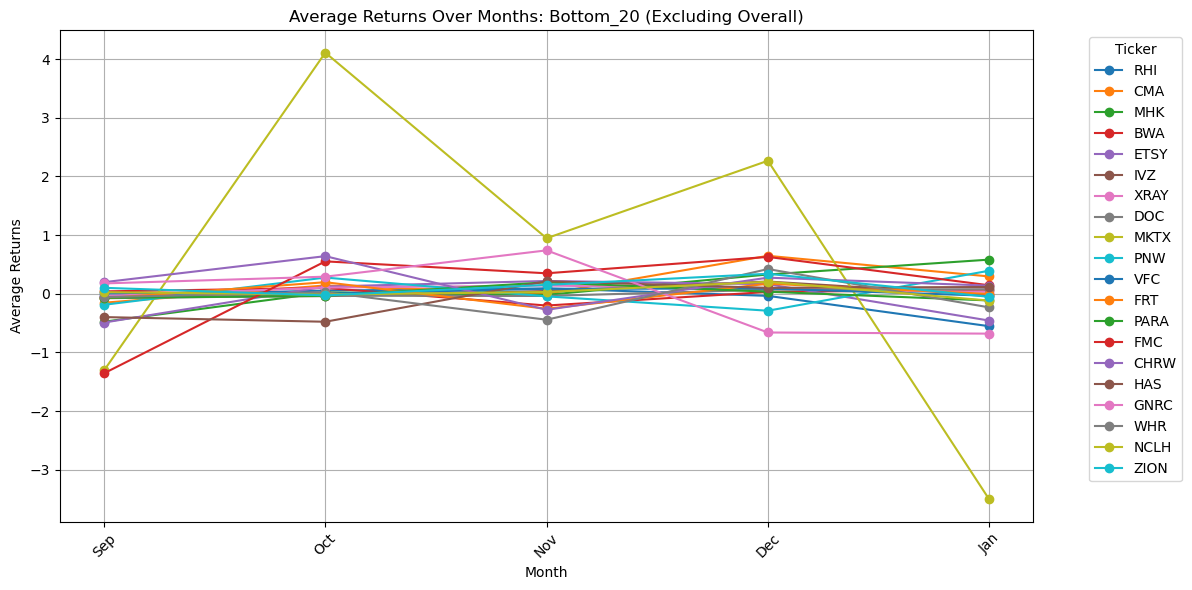

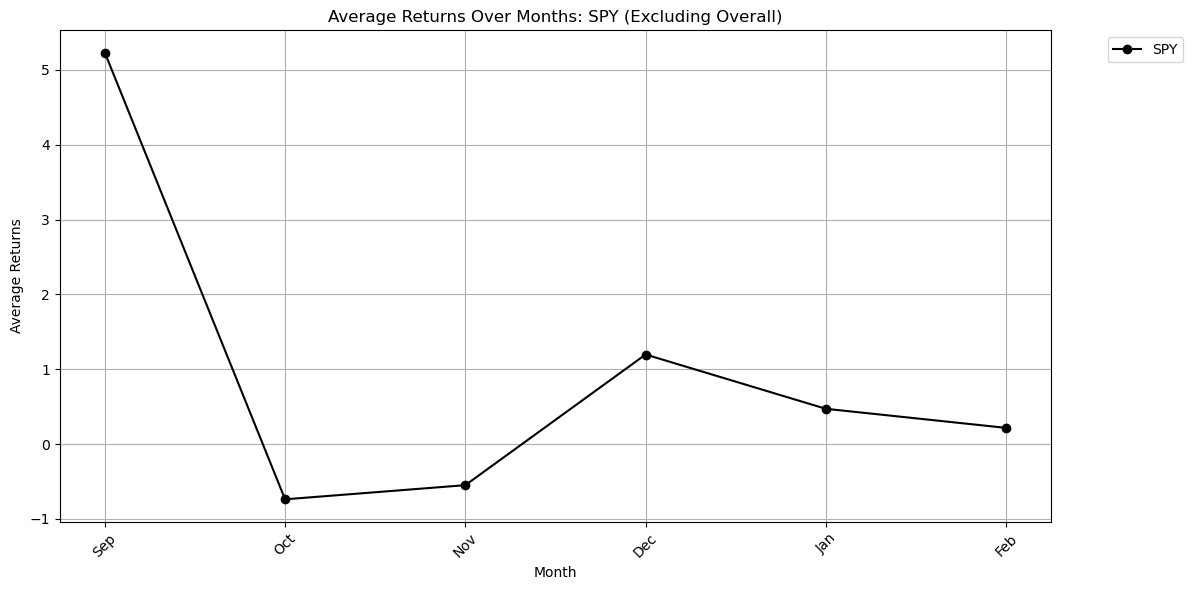

In [19]:
def plot_average_returns_excluding_overall(data, title):
    # Exclude the 'Overall' row for plotting
    if 'Overall' in data.index:
        data_to_plot = data.drop('Overall')
    else:
        data_to_plot = data

    plt.figure(figsize=(12, 6))
    if title == "SPY":  # Handle SPY separately since it's a single series
        plt.plot(data_to_plot.index, data_to_plot['SPY'], marker='o', label='SPY', linestyle='-', color='black')
    else:  # Mag_7 and Bottom_20, which may have multiple columns
        for column in data_to_plot.columns:
            plt.plot(data_to_plot.index, data_to_plot[column], marker='o', linestyle='-', label=column)

    plt.title(f'Average Returns Over Months: {title} (Excluding Overall)')
    plt.xlabel('Month')
    plt.ylabel('Average Returns')
    plt.legend(title='Ticker' if title != "SPY" else '', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting for Mag_7, Bottom_20, and SPY individually, excluding 'Overall'
plot_average_returns_excluding_overall(mag_7_avg_returns, "Mag_7")
plot_average_returns_excluding_overall(bottom_20_avg_returns, "Bottom_20")
plot_average_returns_excluding_overall(spy_avg_returns, "SPY")
